# Delaunay tessellations and
# approximate conformal transformations

*** Goal: define a grid such that the optical depth is well-sampled. ***

The optical depth is defined as:

\begin{align}
d\tau \ = \ \chi(x) \ \textbf{n} \cdot d \textbf{x}
\end{align}

Conformal transformations modify the metric as

\begin{align}
d \textbf{x}'^{2} \ = \ \Omega^{2}(x) \ d \textbf{x}^{2}
\end{align}

and hence preserve angels.

A well-sampled grid in the optical depth would be (approximately) equally spaced in optical depth.

*** Strategy: ***
   - ***Define grid in terms of relations between neighbors, e.g. Delaunay triangulation.***
   - ***Alter neighbor relations to obtain proper sampling.***
   
More specific
- Define grid in terms of its Delaunay triangulation
- Rescale Delaunay edges with the conformal factor.

In [28]:
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.tri    as tri
%matplotlib inline

import numpy as np

In [24]:
class Grid:
    """
    Data structure for the Grid
    """
    def __init__ (self, dimension):
        """
        Initialisation
        """
        # Dimension
        self.dimension = dimension
        # Point coordinates
        self.x = []
        self.y = []
        self.z = []
        
    def ncells (self):
        """
        Return number of cells
        """
        if ((len(self.x) == len(self.y)) and \
            (len(self.y) == len(self.z))     ):
            return len(self.x)
        else:
            print('ERROR: number of points is not well defined.')
            
    def getNeighborLists (self):
        """
        Extract neighbor lists from cell centers assuming Voronoi tesselation
        """
        if   (self.dimension == 0):
            self.nNeighbors = [0]
        elif (self.dimension == 1):
            # For the middle points
            self.neighbors  = [[i-1, i+1] for i in range(1,self.ncells()-1)]
            self.nNeighbors = [2          for i in range(1,self.ncells()-1)]
            # For the end points
            self.neighbors  = [[1]] +  self.neighbors + [[self.ncells()-2]]
            self.nNeighbors =  [1]  + self.nNeighbors +  [1]
        elif (self.dimension == 2):
            points  = [[self.x[i], self.y[i]] for i in range(self.ncells())]
            # Make a Delaulay triangulation
            delaunay = Delaunay(points)
            # Extract Delaunay vertices (= Voronoi neighbors)
            (indptr,indices) = delaunay.vertex_neighbor_vertices
            self.neighbors   = [indices[indptr[k]:indptr[k+1]] for k in range(self.ncells())]
            # Extract the number of neighbors for each point
            self.nNeighbors  = [len(neighborList) for neighborList in self.neighbors]
        elif (self.dimension == 3):
            points  = [[self.x[i], self.y[i], self.z[i]] for i in range(self.ncells())]
            # Make a Delaulay triangulation
            delaunay = Delaunay(points)
            # Extract Delaunay vertices (= Voronoi neighbors)
            (indptr,indices) = delaunay.vertex_neighbor_vertices
            self.neighbors   = [indices[indptr[k]:indptr[k+1]] for k in range(self.ncells())]
            # Extract the number of neighbors for each point
            self.nNeighbors  = [len(neighborList) for neighborList in self.neighbors]
        else:
            print ('ERROR: dimension not set!')

    def points2steps (self):
        """
        Get steps to go from one point to the other
        """
        # Initialise steps
        self.step_x = [[] for _ in range(self.ncells())]
        self.step_y = [[] for _ in range(self.ncells())]
        self.step_z = [[] for _ in range(self.ncells())]
        # Compute steps
        for p in range(self.ncells()):
            for neighbor in self.neighbors[p]:
                self.step_x[p] += [self.x[neighbor] - self.x[p]]
                self.step_y[p] += [self.y[neighbor] - self.y[p]]
                self.step_z[p] += [self.z[neighbor] - self.z[p]]
                
    def steps2points (self):
        """
        Get cell locations from steps
        """
        self.xp = [0.0 for _ in range(self.ncells())]
        self.yp = [0.0 for _ in range(self.ncells())]
        self.zp = [0.0 for _ in range(self.ncells())]
        # Origin is done
        self.xp[0] = self.x[0]
        self.yp[0] = self.y[0]
        self.zp[0] = self.z[0]
        # Locate neighbors
        self.locateNeighbors(0)
        
    def locateNeighbors (self, p):
        if not done[p]:
            # Indicate that point n is (being) done
            done[p] = True
            #print(f'    p {p}')
            for n in range(self.nNeighbors[p]):
                # Locate neighbor n
                self.xp[self.neighbors[p][n]] = self.x[p] + self.step_x[p][n]
                self.yp[self.neighbors[p][n]] = self.y[p] + self.step_y[p][n]
                self.zp[self.neighbors[p][n]] = self.z[p] + self.step_z[p][n]
                # Do the same for its neighbors
                self.locateNeighbors(self.neighbors[p][n])
                
    def conformalMap (self):
        # Initialise steps
        #self.x_new = [0.0 for _ in range(self.ncells())]
        #self.y_new = [0.0 for _ in range(self.ncells())]
        #self.z_new = [0.0 for _ in range(self.ncells())]
        # Compute corrections for the new coordiates
        for p in range(self.ncells()):
            for n in range(self.nNeighbors[p]):
                scale = omega(self.x[p], self.y[p], self.z[p])
                self.x[self.neighbors[p][n]] = self.x[p] + self.step_x[p][n] * scale
                self.y[self.neighbors[p][n]] = self.y[p] + self.step_y[p][n] * scale
                self.z[self.neighbors[p][n]] = self.z[p] + self.step_z[p][n] * scale
        ## Add corrections to the original coordinates
        #for p in range(self.ncells()):
        #    self.x_new[p] = self.x_new[p] / float(self.nNeighbors[p]) #+ self.x[p]
        #    self.y_new[p] = self.y_new[p] / float(self.nNeighbors[p]) #+ self.y[p]
        #    self.z_new[p] = self.z_new[p] / float(self.nNeighbors[p]) #+ self.z[p]

    def scale (self, p, n):
        integrate
            
def omega (x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return 1.0+r

In [25]:
# Define Cubic grid

grid = Grid(dimension=2)

dx = 0.1
dy = 0.1

nx = 7
ny = 7

for i in range(-nx,nx):
    for j in range(-ny,ny):
        grid.x += [i*dx + (j%2)*dx/2.0]
        grid.y += [j*dx*np.sqrt(3)/2.0]
        grid.z += [0.0]

In [26]:
# Initialise "done"
done = [False for p in range(grid.ncells())]

grid.getNeighborLists()
grid.points2steps()
grid.conformalMap()

#for p in range(grid.ncells()):
#    print(grid.x[p]-grid.xp[p])

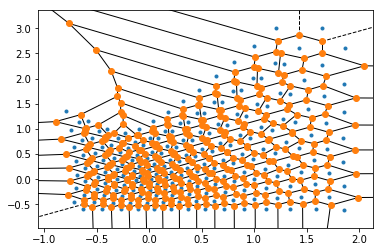

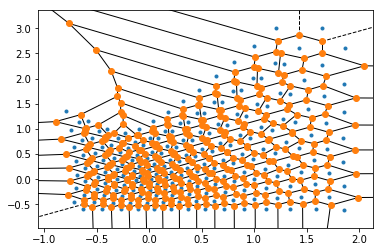

In [27]:
# Plot Voronoi tessellation

points = [[grid.x[p], grid.y[p]] for p in range(grid.ncells())]
vor    = Voronoi(points)
voronoi_plot_2d(vor)

In [12]:
# Plot Voronoi tessellation

points = [[grid.x_new[p], grid.y_new[p]] for p in range(grid.ncells())]
vor    = Voronoi(points)
voronoi_plot_2d(vor)

AttributeError: 'Grid' object has no attribute 'x_new'

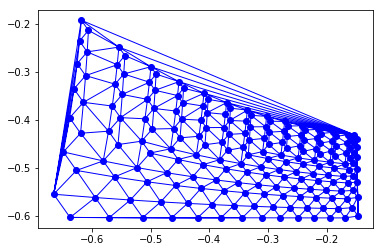

In [13]:
# Plot Delaunay triangulation

triang = tri.Triangulation(grid.x, grid.y)
plt.triplot(triang, 'bo-', lw=1)

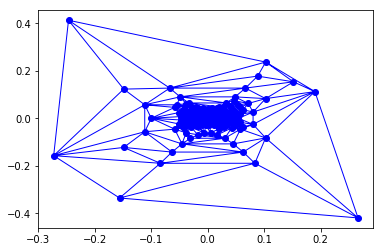

In [242]:
# Plot Delaunay triangulation

triang = tri.Triangulation(grid.x_new, grid.y_new)
plt.triplot(triang, 'bo-', lw=1)

In [11]:
print(triang)

In [178]:
for N in grid.nNeighbors:
    print(f'    {N}')

    3
    4
    5
    5
    5
    5
    5
    5
    5
    5
    5
    5
    5
    3
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    4
    4
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    6
    

In [103]:
def rho(r):
    return 1.0 / (3.0 + r**2)

def drho(r):
    return - 2.0 * r / (3.0 + r**2)**2

1.6157641180811062


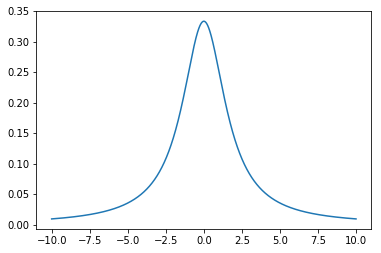

In [61]:
N = 100000

x = np.linspace(-10.0, 10.0, N)
plt.plot(x, rho(x))

L = 20.0

P = 0.0
for i in range(1, N):
    P += rho(x[i])*(x[i] - x[i-1])

print(P)

In [72]:
tot = 10000

pt = np.linspace(-10.0, 10.0, tot)
px = []

part = P / float(tot)


integral = 0.0

for i in range(1, N):
    integral += rho(x[i])*(x[i] - x[i-1])
    if (integral >= part):
        integral = 0.0
        px += [x[i]]

print(len(px))

9060


(array([ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
         2.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,
         2.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,
         1.,  2.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,
         1.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,
         2.,  2.,  1.,  2.,  1.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,  1.,
         2.,  2.,  1.,  2.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,
         1.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  3.,
         2.,  2.,  3.,  2.,  2.,  2.,  3.,  2.,  3.,  2.,  2.,  3.,  2.,
         3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,
         3.,  2.,  3.,  3.,  2.,  3.,  3.,  2.,  3.

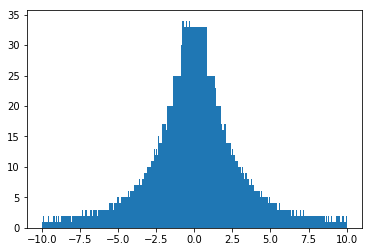

In [65]:
plt.hist(px,1000)

In [73]:
[(rho(pt[i])+rho(pt[i-1]))*(pt[i]-pt[i-1]) for i in range(1, tot)]

[3.884637979106343e-05,
 3.8861473046936034e-05,
 3.887657501279631e-05,
 3.8891685695416324e-05,
 3.890680510129822e-05,
 3.8921933237226676e-05,
 3.893707010971623e-05,
 3.8952215725529605e-05,
 3.896737009133216e-05,
 3.898253321369169e-05,
 3.899770509942454e-05,
 3.901288575507637e-05,
 3.902807518747625e-05,
 3.904327340318236e-05,
 3.905848040903651e-05,
 3.9073696211609424e-05,
 3.908892081772094e-05,
 3.910415423409324e-05,
 3.9119396467350604e-05,
 3.91346475243668e-05,
 3.9149907411744046e-05,
 3.916517613636891e-05,
 3.9180453704856265e-05,
 3.919574012407074e-05,
 3.9211035400779125e-05,
 3.9226339541650025e-05,
 3.9241652553602285e-05,
 3.925697444328246e-05,
 3.927230521762232e-05,
 3.9287644883281146e-05,
 3.930299344716877e-05,
 3.931835091609689e-05,
 3.933371729677885e-05,
 3.934909259617888e-05,
 3.936447682098823e-05,
 3.937986997818421e-05,
 3.93952720744709e-05,
 3.941068311680366e-05,
 3.942610311203948e-05,
 3.944153206693673e-05,
 3.945696998850545e-05,
 3.947

In [74]:
[(rho(px[i])+rho(px[i-1]))*(px[i]-px[i-1]) for i in range(1, len(px))]

[0.0003239106508395448,
 0.0003249597142325939,
 0.00032601383064024544,
 0.00032707303222571525,
 0.00032417752459323987,
 0.0003252213180515976,
 0.00032627010903467965,
 0.0003233257962888889,
 0.0003243589479840102,
 0.000325397008153245,
 0.0003264400076050839,
 0.0003234384965804007,
 0.00032446556863228776,
 0.00032549748915030105,
 0.00032653428836737665,
 0.0003234748372312532,
 0.00032449542228843594,
 0.00032552079350528333,
 0.0003265509805252686,
 0.0003234328566623674,
 0.00032444654448427916,
 0.00032546495389413927,
 0.00032648811393269753,
 0.00032331059500748425,
 0.00032431697291480645,
 0.0003253280056111028,
 0.00032634372152152665,
 0.00032736414928595466,
 0.00032411792060197433,
 0.00032512122027944377,
 0.00032612913392694086,
 0.0003271416895532446,
 0.0003238344004201344,
 0.00032482954854097567,
 0.00032582923923162954,
 0.00032683349985869296,
 0.00032346446031815315,
 0.00032445103734956123,
 0.000325442083447042,
 0.0003264376253242678,
 0.000327437689892

In [89]:
def rho(x, y):
    return 1.0 / (3.0 + x**2 + y**2)

11.436690377387967


/home/frederik/software/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


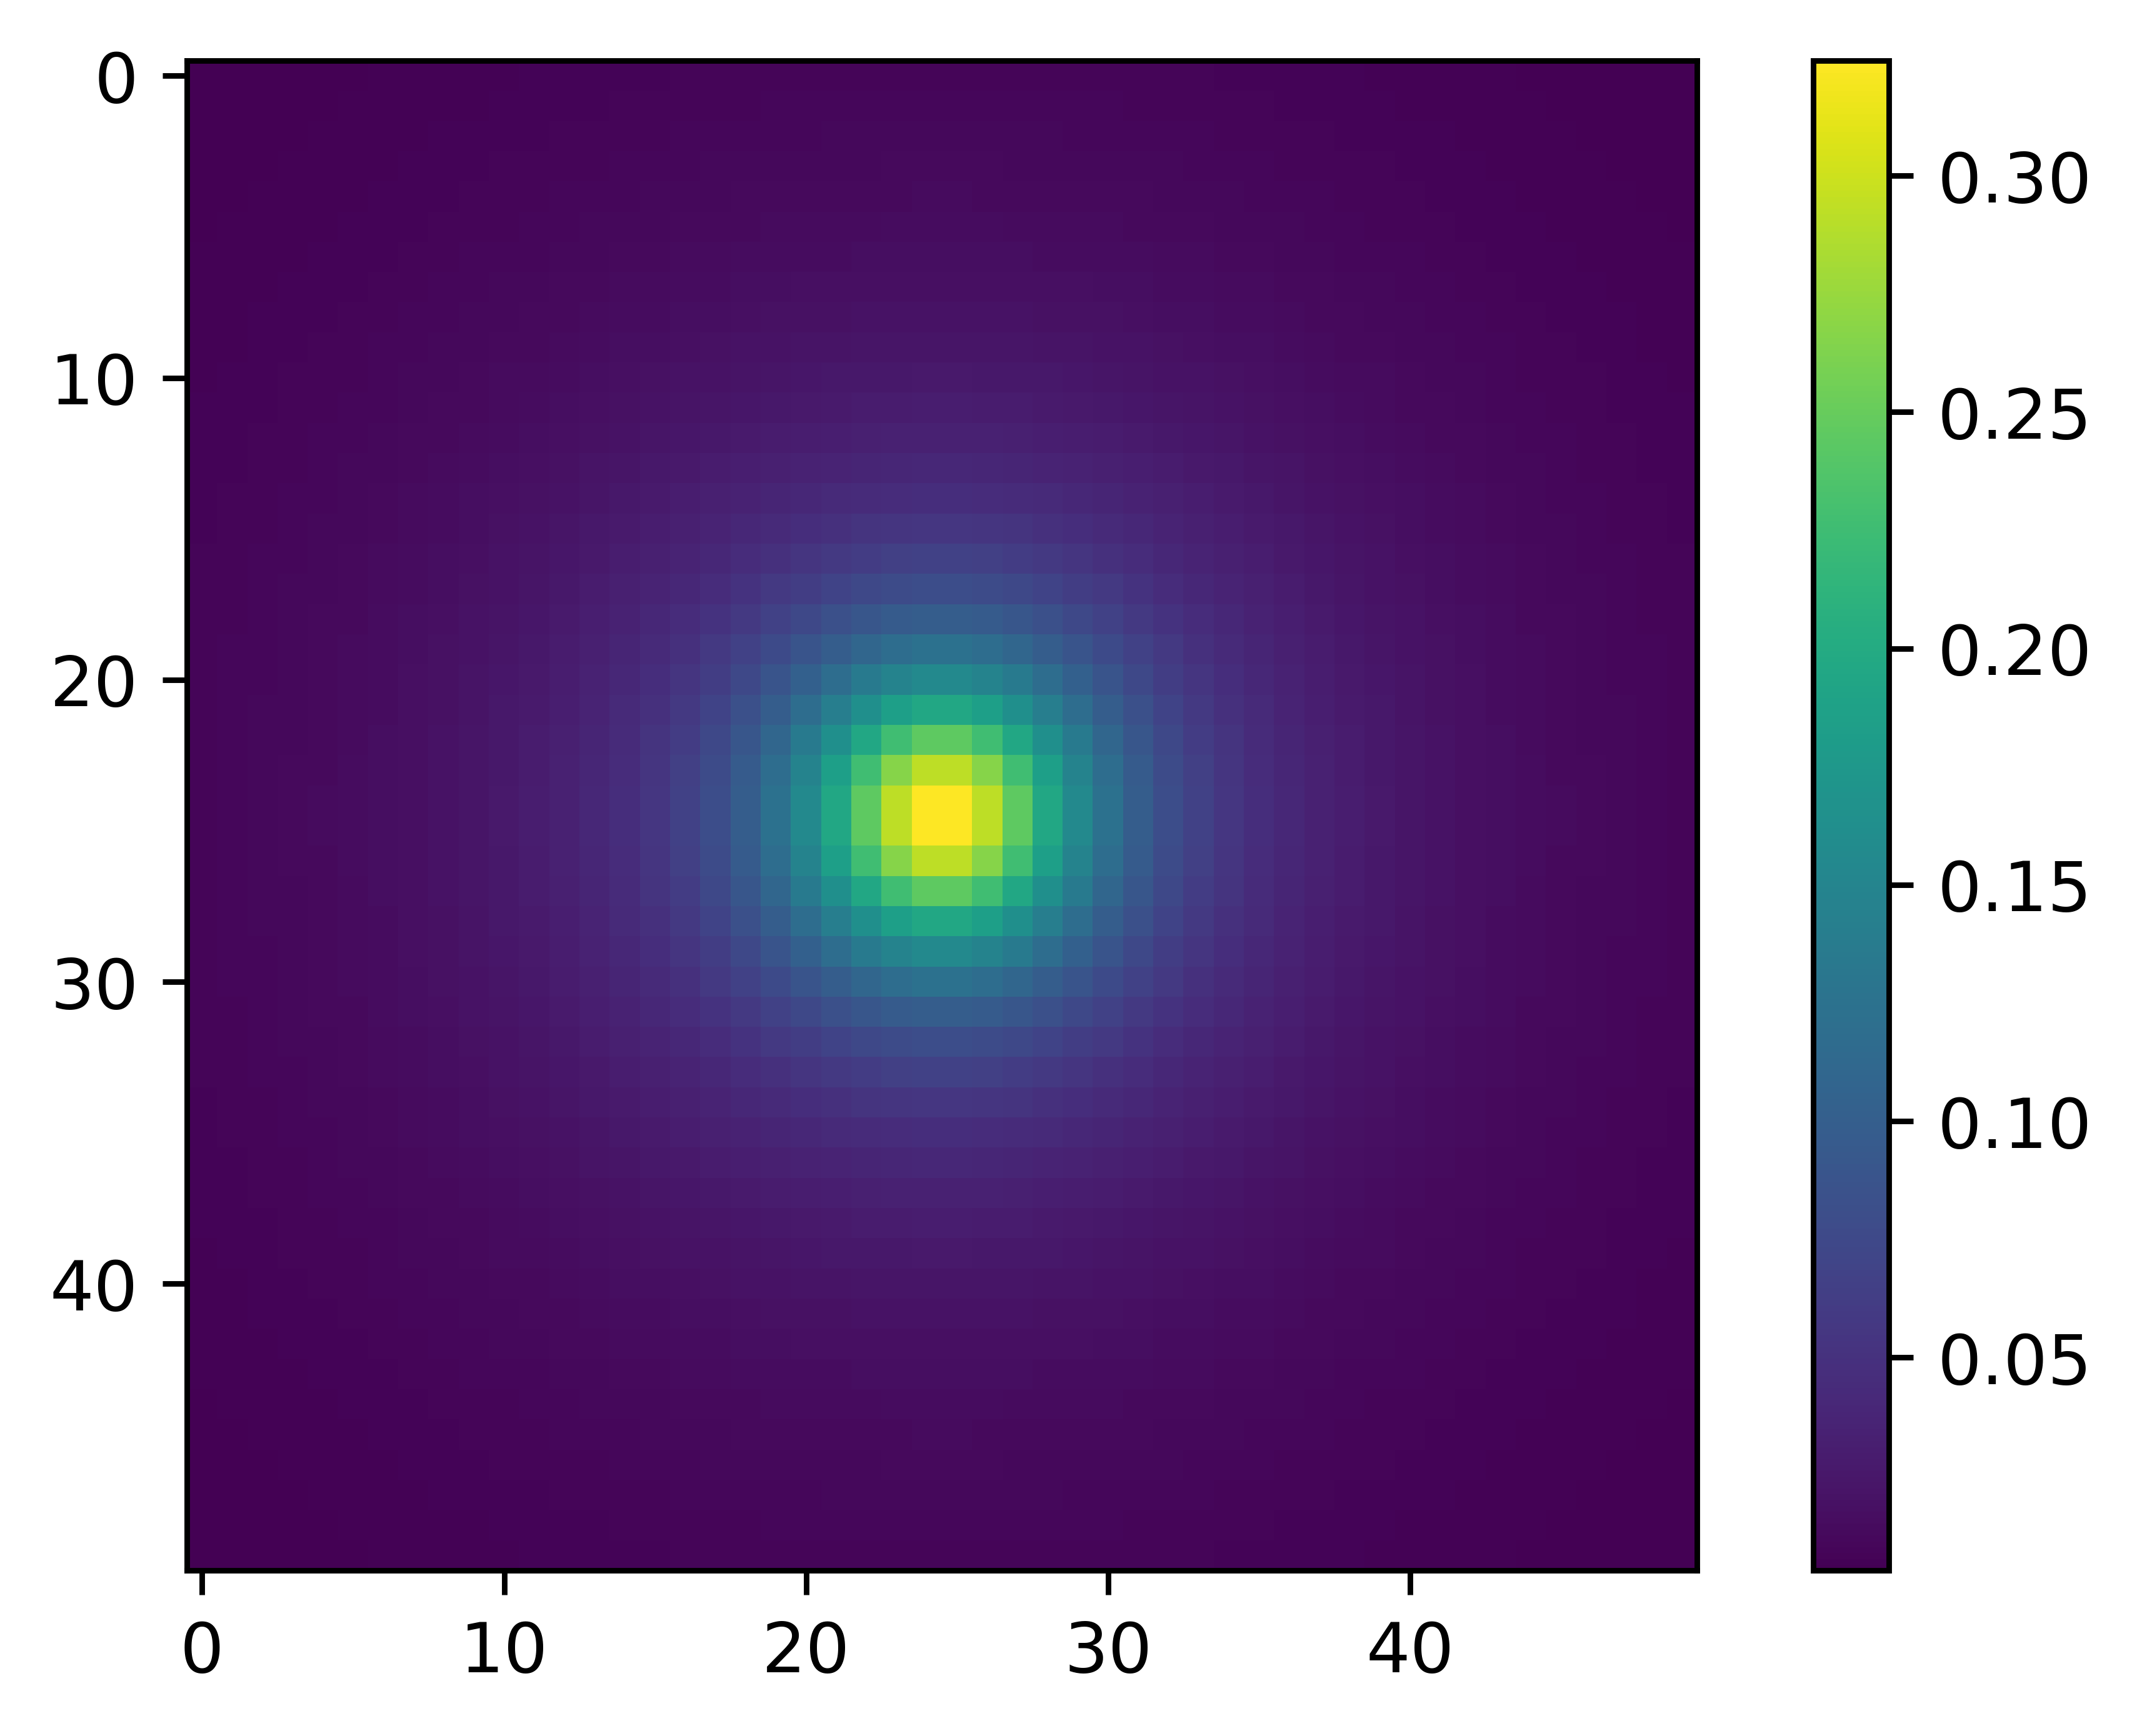

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

x_max = +10.0
x_min = -10.0
n_x = 50

y_max = +10.0
y_min = -10.0
n_y = 50

im = [[rho(x, y) for y in np.linspace(y_min, y_max, n_y)] for x in np.linspace(x_min, x_max, n_x)]

dx = (x_max - x_min) / float(n_x)
dy = (y_max - y_min) / float(n_y)

print(np.sum(im)*dx*dy)

plt.figure(dpi=800)
plt.imshow(im)
plt.colorbar()
plt.axes().set_aspect('equal')

r = -10.0 	 dr = 0.47178108829630233
-9.528218911703698
r = -9.528218911703698 	 dr = 0.4311619029594389
-9.09705700874426
r = -9.09705700874426 	 dr = 0.3955822570206781
-8.701474751723582
r = -8.701474751723582 	 dr = 0.36424571169953474
-8.337229040024047
r = -8.337229040024047 	 dr = 0.3365067035574188
-8.000722336466628
r = -8.000722336466628 	 dr = 0.3118375684476347
-7.688884768018994
r = -7.688884768018994 	 dr = 0.28980366714223427
-7.39908110087676
r = -7.39908110087676 	 dr = 0.27004441703511795
-7.129036683841642
r = -7.129036683841642 	 dr = 0.2522586813857821
-6.87677800245586
r = -6.87677800245586 	 dr = 0.2361934095463668
-6.6405845929094935
r = -6.6405845929094935 	 dr = 0.22163472779616228
-6.418949865113332
r = -6.418949865113332 	 dr = 0.20840089530785605
-6.210548969805475
r = -6.210548969805475 	 dr = 0.1963366924477891
-6.014212277357686
r = -6.014212277357686 	 dr = 0.18530891832134602
-5.82890335903634
r = -5.82890335903634 	 dr = 0.17520275414763647
-5.6537006

(array([ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,
         0.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  3.,
         2.,  2.,  3.,  3.,  4.,  3.,  5.,  4.,  6.,  6.,  7.,  8.,  9.,
        10., 11., 13., 13., 15., 14., 15., 14., 14., 12., 11.,  9.,  9.,
         8.,  6.,  6.,  5.,  5.,  4.,  3.,  3.,  3.,  3.,  2.,  3.,  1.,
         2.,  2.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  1.,  1.,
         1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([-10.        ,  -9.77718866,  -9.55437732,  -9.33156598,
         -9.10875464,  -8.8859433 ,  -8.66313196,  -8.44032062,
         -8.21750928,  -7.99469794,  -7.7718866 ,  -7.54907526,
         -7.32626392,  -7.10345258,  -6.88064124,  -6.6578299 ,
         -6.43501856,  -6.21220722,  -5.98939588,  -5.76658454,
         -5.5437732 ,  -5.32096186,  -5.09815052,  -4.87533918,
         -4.65252784,  -4.4297165 ,  -4.20690516,  -3.98409382,
         -3.76128248,  -3.53847114,  -3.3156

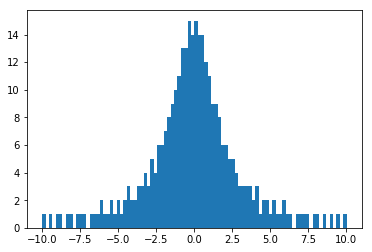

In [153]:
b = 5.0E-3

def cube_root(x):
    if (x >= 0):
        return x**(1.0/3.0)
    else:
        return -(-x)**(1.0/3.0)

def rho(r):
    return       1.0 / (3.0 + r**2)

def drho(r):
    return - 2.0 * r / (3.0 + r**2)**2

def dr(r):
    ddr = 1.0 / (2.0 * drho(r)) * (-rho(r) + np.sqrt(rho(r)**2 + 4.0*drho(r)*b))
    print(f'r = {r} \t dr = {ddr}')
    return ddr


x = -10.
a = [x]

dr_max = 1
ddr    = 0.01

while (x < x_max):
    ddr_new = dr(x)
    if (ddr_new > 0 and ddr_new < dr_max):
        ddr = ddr_new
    x += ddr
    print(x)
    a += [x]

print(len(a))

           
plt.hist(a,90)

r = -10.0 	 dr = 0.47178108829630233
r = -9.97997997997998 	 dr = 0.4700217947158319
r = -9.95995995995996 	 dr = 0.4682656490846644
r = -9.93993993993994 	 dr = 0.46651265265184205
r = -9.91991991991992 	 dr = 0.4647628066677808
r = -9.8998998998999 	 dr = 0.46301611238427215
r = -9.87987987987988 	 dr = 0.4612725710544849
r = -9.85985985985986 	 dr = 0.45953218393296597
r = -9.83983983983984 	 dr = 0.45779495227564687
r = -9.81981981981982 	 dr = 0.45606087733984285
r = -9.7997997997998 	 dr = 0.45432996038425605
r = -9.77977977977978 	 dr = 0.45260220266897855
r = -9.75975975975976 	 dr = 0.45087760545549316
r = -9.73973973973974 	 dr = 0.4491561700066791
r = -9.71971971971972 	 dr = 0.44743789758681146
r = -9.6996996996997 	 dr = 0.4457227894615637
r = -9.67967967967968 	 dr = 0.444010846898013
r = -9.65965965965966 	 dr = 0.4423020711646393
r = -9.63963963963964 	 dr = 0.4405964635313293
r = -9.61961961961962 	 dr = 0.4388940252693799
r = -9.5995995995996 	 dr = 0.4371947576514992

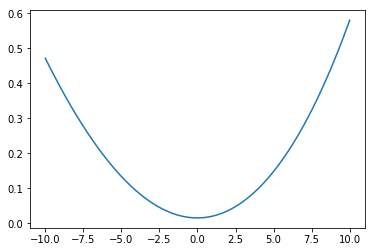

In [151]:
x = np.linspace(-10.0, 10.0, 1000)
print([dr(xi) for xi in x])
plt.plot(x, [dr(xi) for xi in x])

In [131]:
dr(5)

-0.3999776003135999
r = 5 	 dr = nan


/home/frederik/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


nan

In [ ]:
import sympy

x, y = sympy.symbols("x y", real=True)

rho_a   = rho(x_a, y_a)
dxrho_a = dxrho(x_a, y_a)
dyrho_a = dyrho(x_a, y_a)

rho_b   = rho(x_b, y_b)
dxrho_b = dxrho(x_b, y_b)
dyrho_b = dyrho(x_b, y_b)

eq1 = sympy.Eq((2.0*rho_a + (x-x_a)*dxrho_a + (y-y_a)*dyrho_a)**2 * ((x-x_a)**2+(y-y_a)**2) - 4.0*b**2)
eq1 = sympy.Eq((2.0*rho_b + (x-x_b)*dxrho_b + (y-y_b)*dyrho_b)**2 * ((x-x_b)**2+(y-y_b)**2) - 4.0*b**2)

In [154]:
def rho(x, y):
    return 1.0 / (3.0 + x**2 + y**2)

11.436690377387967


/home/frederik/software/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


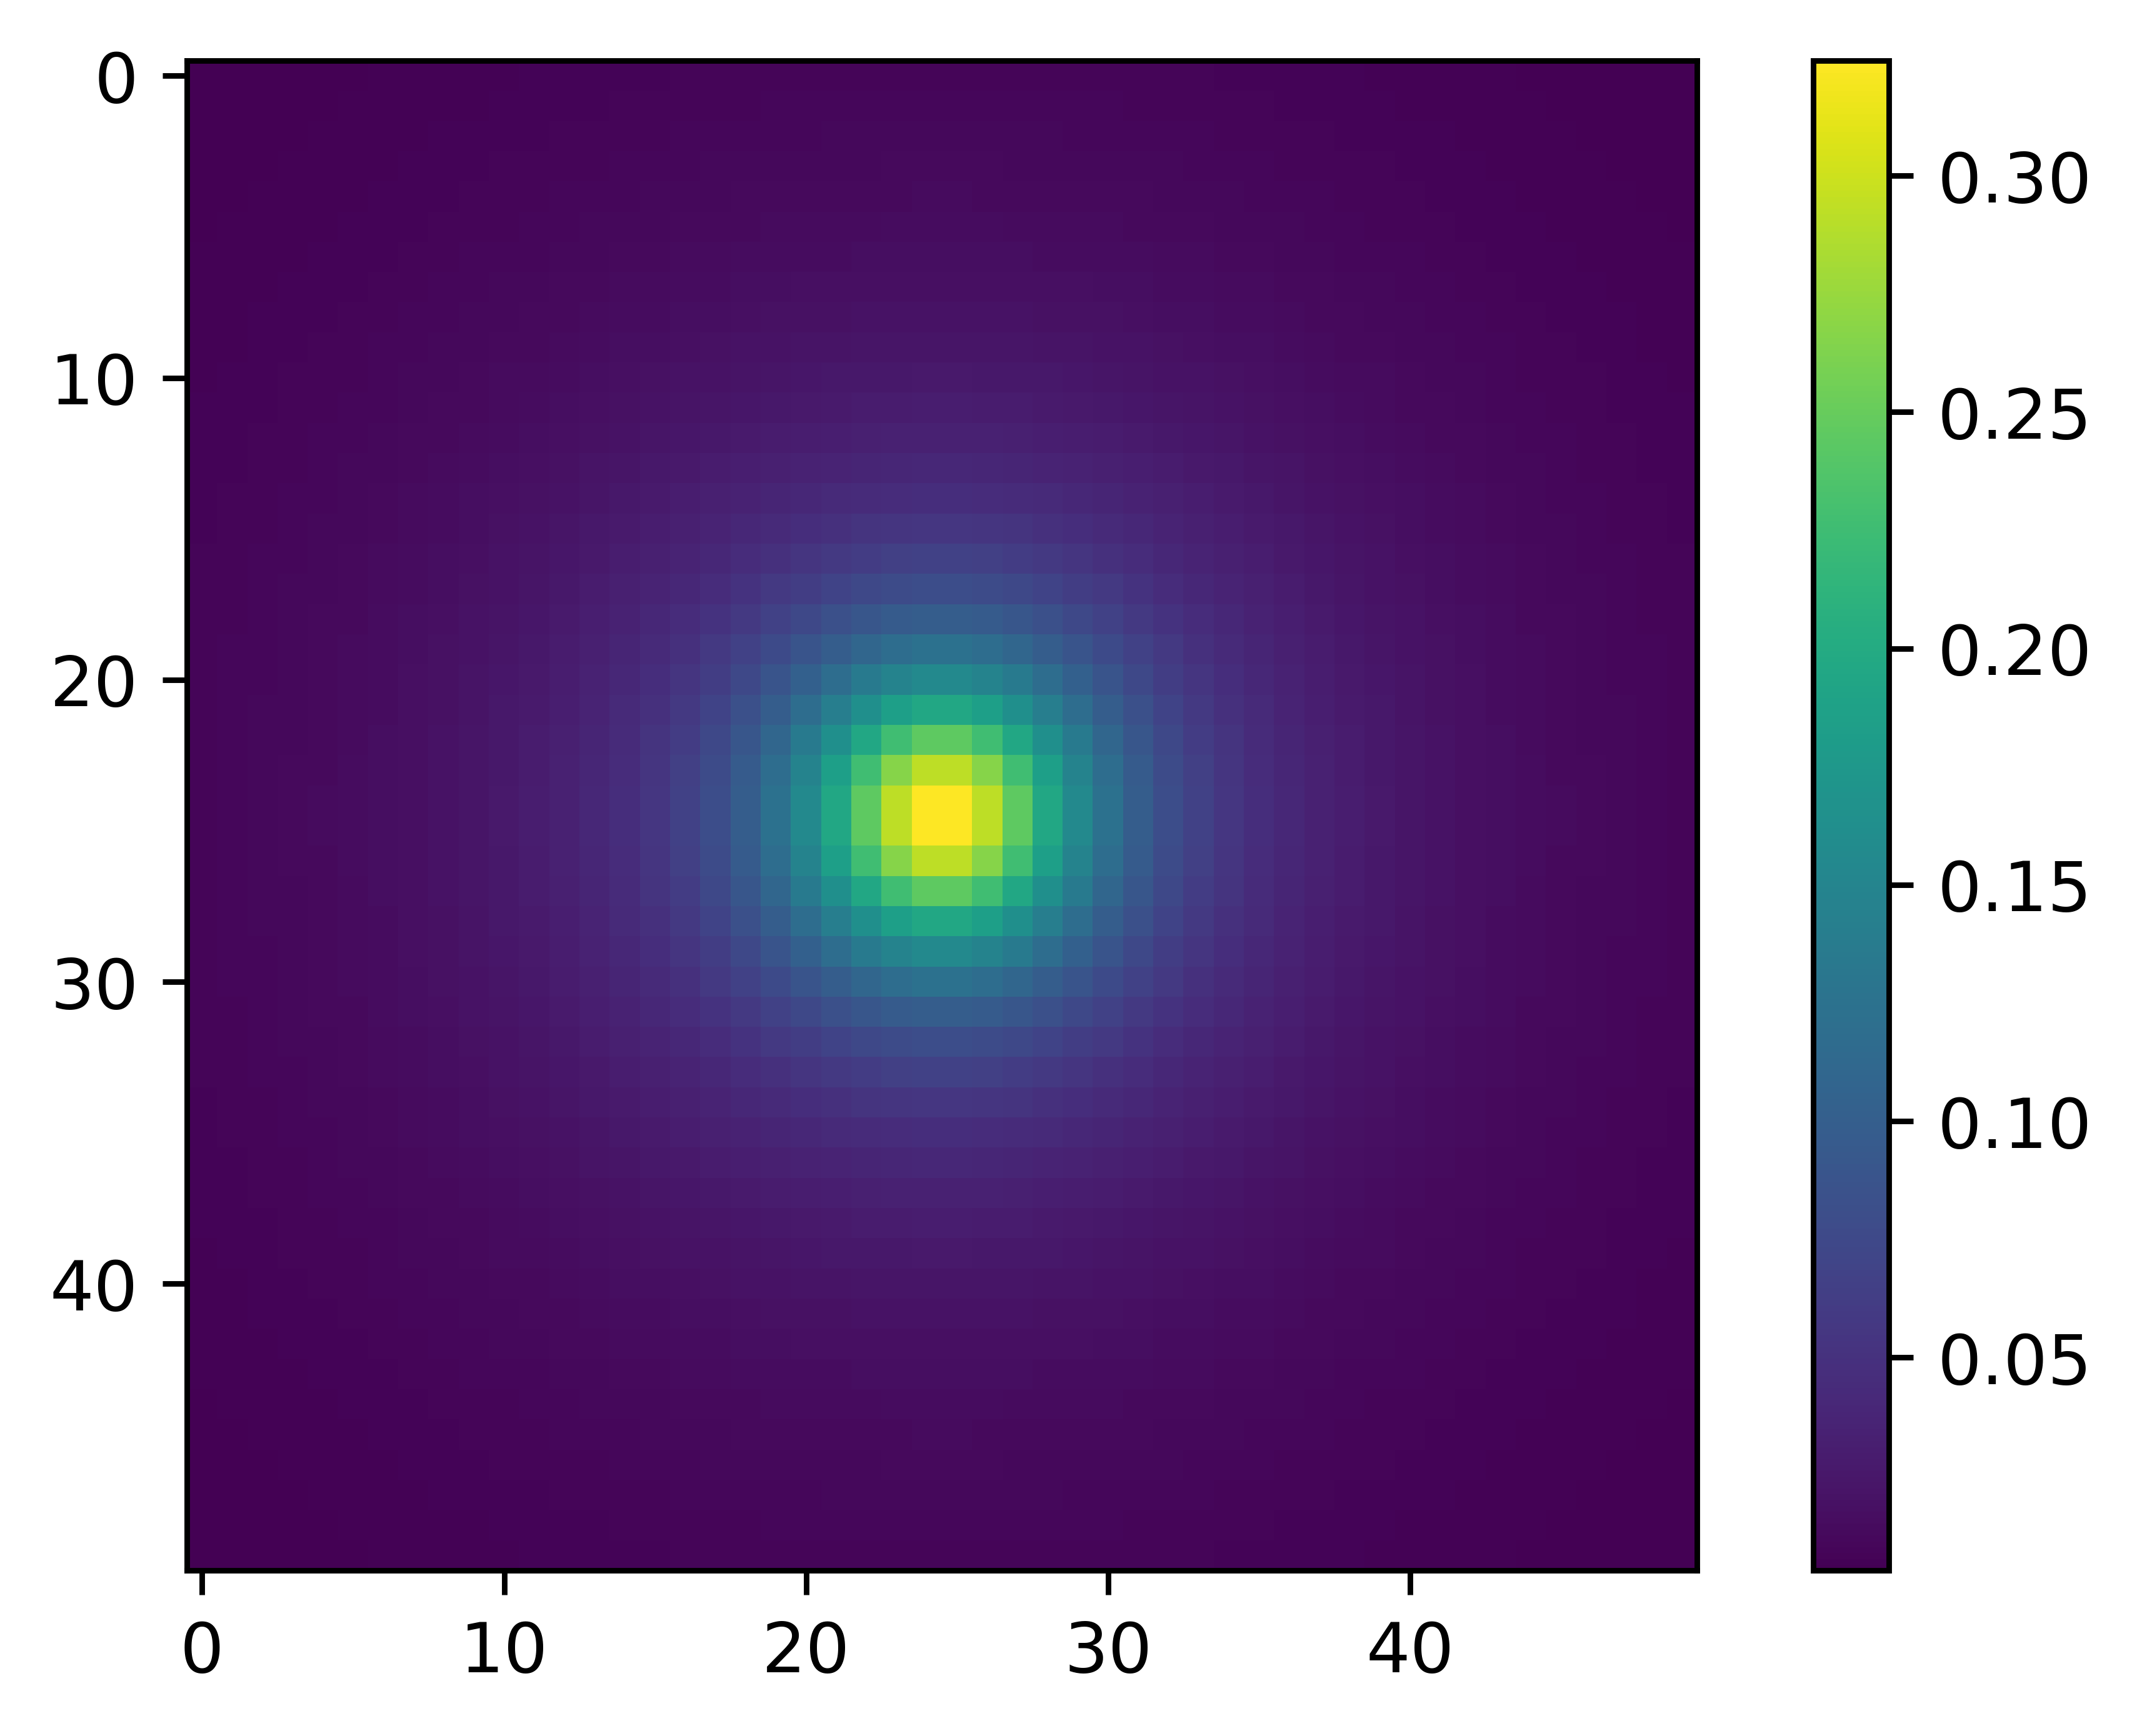

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline

x_max = +10.0
x_min = -10.0
n_x = 50

y_max = +10.0
y_min = -10.0
n_y = 50

im = [[rho(x, y) for y in np.linspace(y_min, y_max, n_y)] for x in np.linspace(x_min, x_max, n_x)]

dx = (x_max - x_min) / float(n_x)
dy = (y_max - y_min) / float(n_y)

print(np.sum(im)*dx*dy)

plt.figure(dpi=800)
plt.imshow(im)
plt.colorbar()
plt.axes().set_aspect('equal')

In [156]:
 np.min(im)

0.0049261083743842365

In [157]:
image = im / np.min(im)

In [159]:
np.sum(image)

14510.300916310982

/home/frederik/software/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


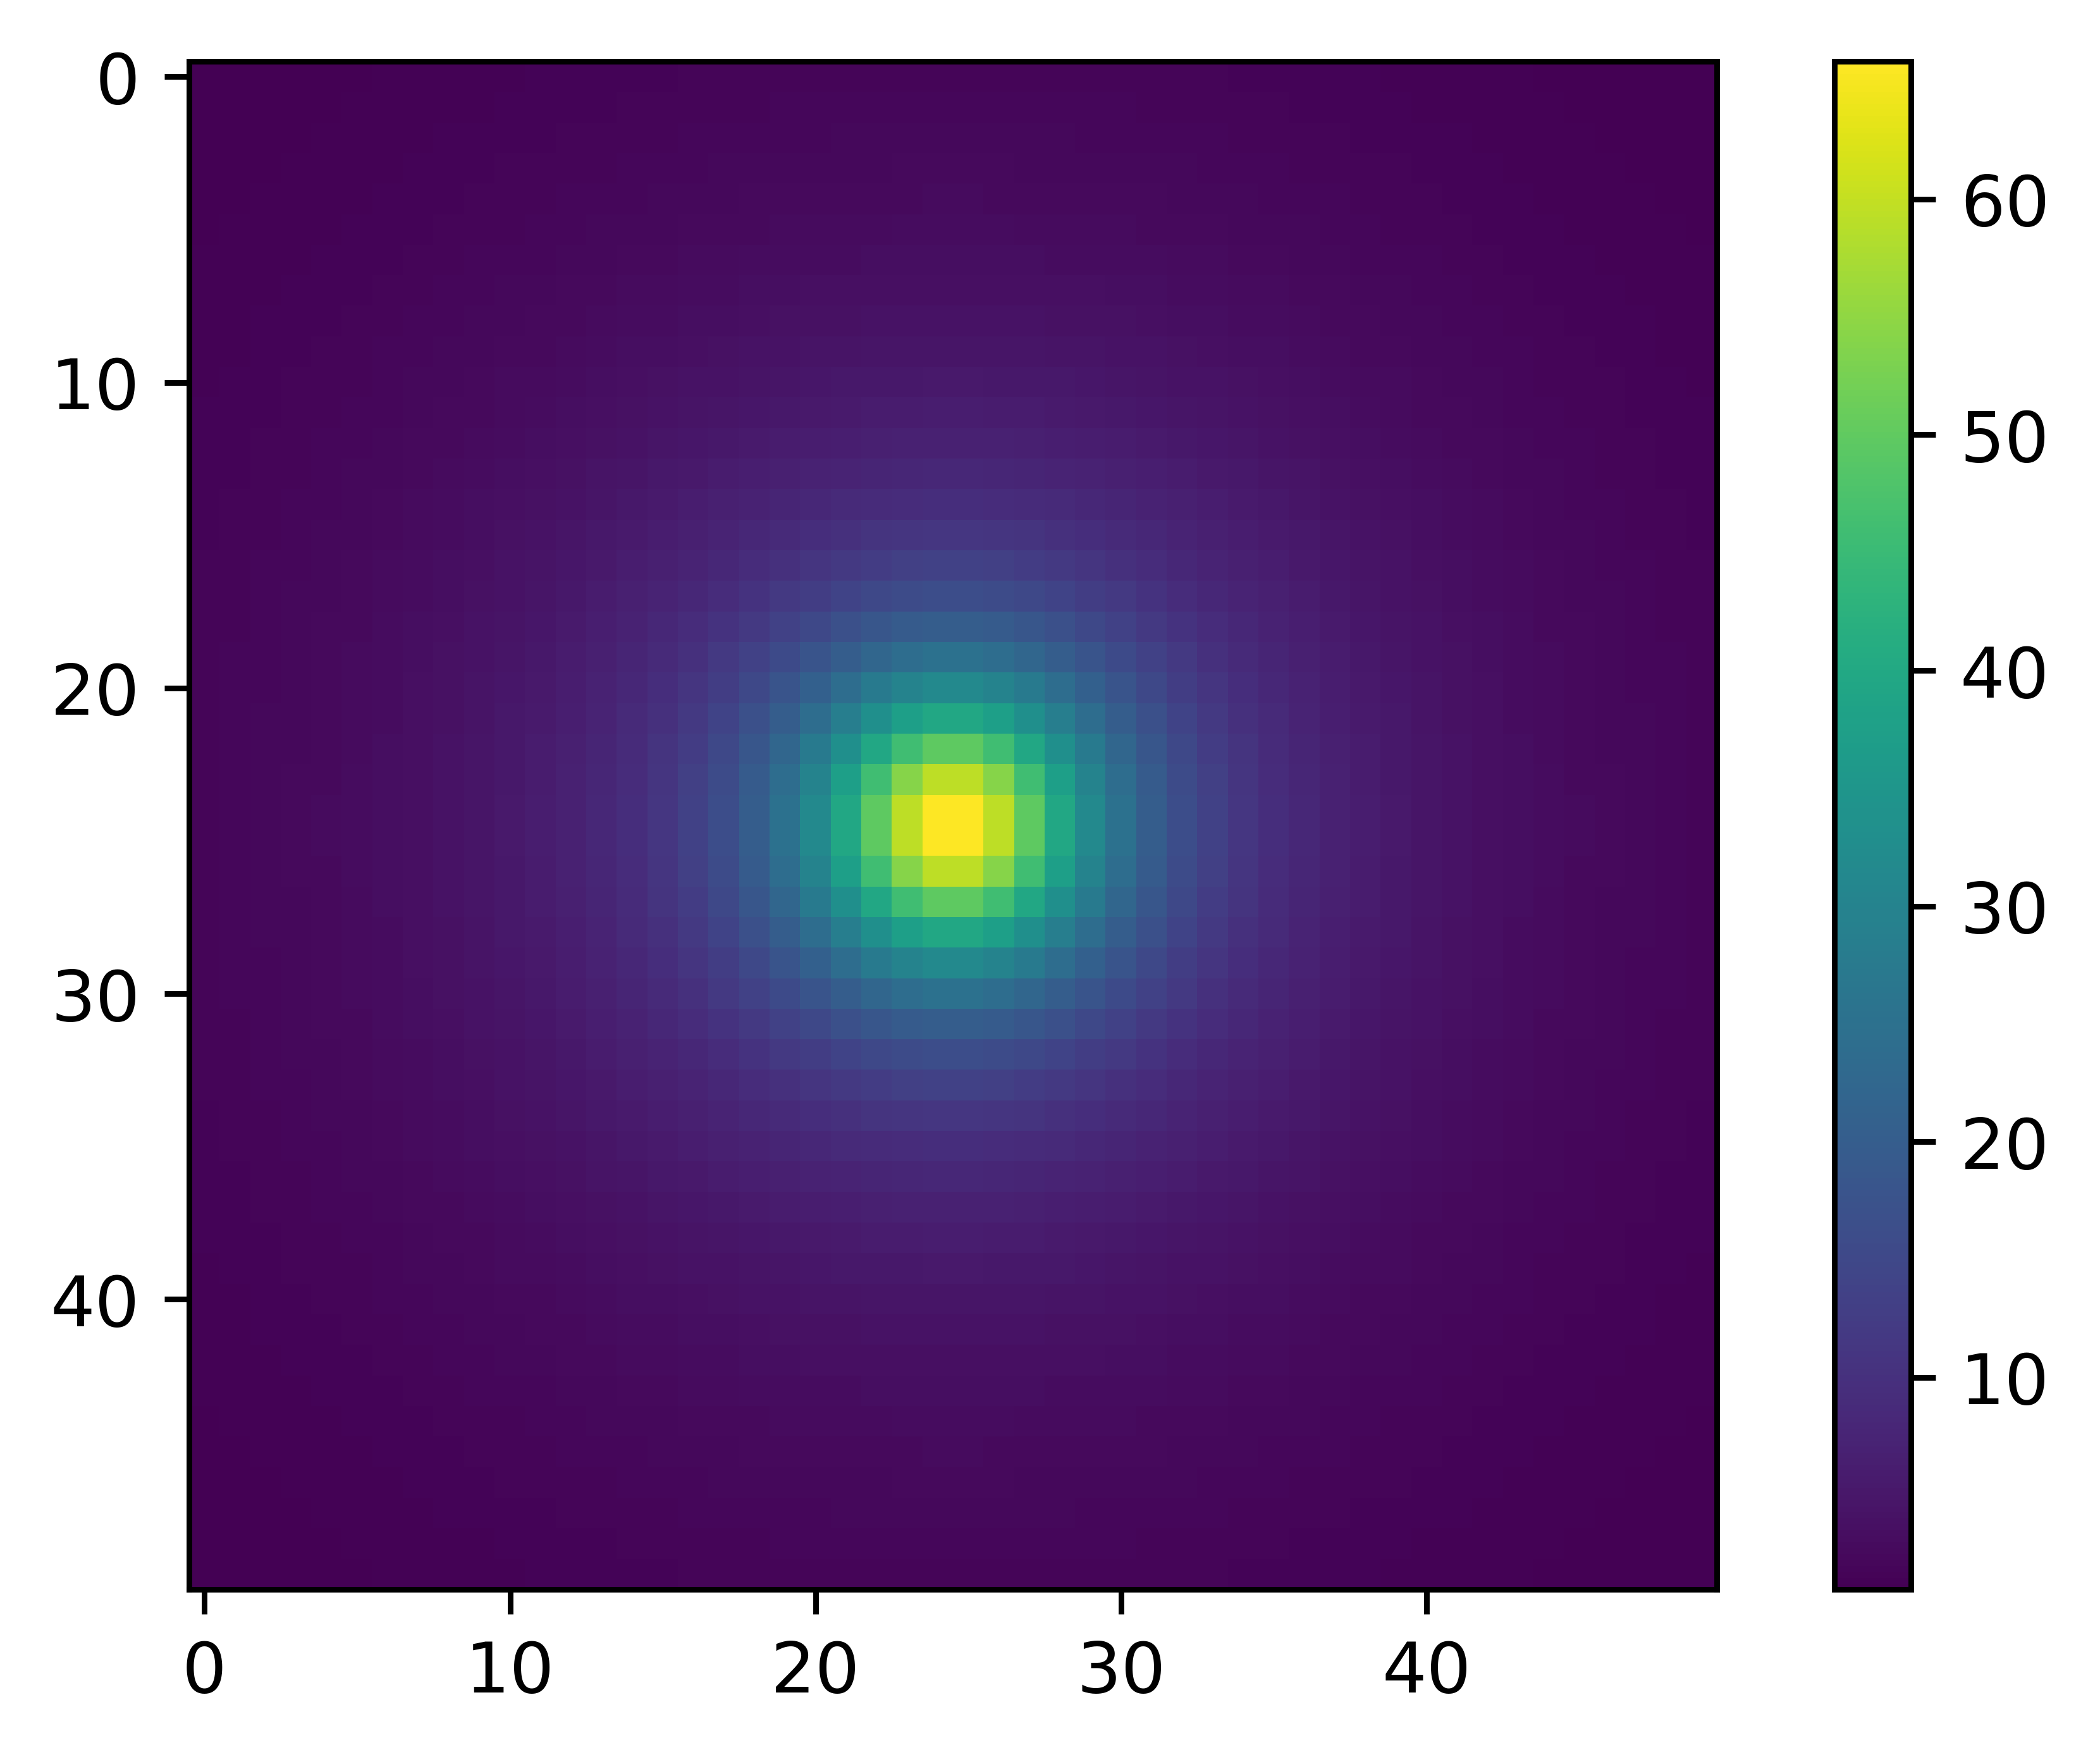

In [158]:
plt.figure(dpi=800)
plt.imshow(image)
plt.colorbar()
plt.axes().set_aspect('equal')

# Create an input grid/mesh


**Information** we need from the grid/mesh:
- locations of the cell centers,
- nearest neighbor lists.

**Properties** we want for the grid/mesh:

For *solver* purposes
- edge lengths of the corresponding triangulation to follow a certain distribution,

For *image* purposes
- the projected point distribution to follow the gradient of that distribution.

So a point should either have high density or high density gradient. This leads to the distribution function

\begin{align}
p(\textbf{x}) \ = \ w_{1} \rho(\textbf{x}) \ + \ w_{2} \| \nabla\rho(\textbf{x}) \|
\end{align}

A better strategy might be to draw points from the density distribution and then afterwords add points if there are underrepresented regions with strong gradients.
